- 特徴量を追加してみる

In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload 2

import os
import sys
import json
import gc
import pickle 


from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append("../")
from src.model import MLModel, LightGBMModel
from src.validation import caluculate_metrics

# Config

In [5]:
class cfg:
    exp = "exp011"
    dataset_path = "../dataset/v5.0"
    feature_set = "small"
    
    model_params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }


In [6]:
# 実験用フォルダ作成    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)

with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set]
print(f"feature col length: {len(feature_set)}")

feature col length: 42


# Load Data

In [7]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era", "target"] + feature_set
)

valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era", "target"] + feature_set
)

print(train.shape)
display(train.head(2))

print(valid.shape)
display(valid.head(2))

(2746270, 44)


,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,0.25,2,2,2,2,2,0,1,2,...,4,1,1,3,0,2,2,3,3,2
n003bba8a98662e4,0001,0.25,2,2,2,2,2,1,4,2,...,4,2,0,0,0,2,2,4,4,2


(3577827, 44)


,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0.75,0,2,1,2,2,1,1,2,...,1,2,3,0,2,2,1,3,2,0
n001e1318d5072ac,0575,0.00,1,1,3,2,1,3,3,4,...,2,4,3,2,2,3,1,1,0,1


# Preprocess

In [8]:
# target が 20 日、 era が週次なので重複してる。ので era を間引く
train["era_int"] = train["era"].astype(int)
cond_train = train["era_int"] % 4 == 0
train = train.loc[cond_train]

In [10]:
def add_feature(df):
    # era 内の平均
    for col in feature_set:
        df[f"per_era_mean_{col}"] = df.groupby("era")[col].transform("mean")
    return df

train = add_feature(train)
valid = add_feature(valid)

In [11]:
display(train.head())

,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,per_era_mean_feature_tridactyl_immoral_snorting,per_era_mean_feature_trimeter_soggy_greatest,per_era_mean_feature_unanalyzable_excusable_whirlwind,per_era_mean_feature_unbreakable_constraining_hegelianism,per_era_mean_feature_unformed_bent_smatch,per_era_mean_feature_unministerial_unextenuated_teleostean,per_era_mean_feature_unmodish_zymogenic_rousing,per_era_mean_feature_unsystematized_subcardinal_malaysia,per_era_mean_feature_willful_sere_chronobiology,per_era_mean_feature_zoological_peristomial_scute
id,,,,,,,,,,,,,,,,,,,,,
n00056da8c4dbefd,0004,0.75,2,2,2,2,2,2,2,2,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
n0036cbd876e486d,0004,0.75,2,2,2,2,2,1,1,2,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
n004546e568788e4,0004,0.50,2,2,2,2,2,3,4,2,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
n00662a7dff7d7d4,0004,0.50,2,2,2,2,2,4,3,2,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
n00c2e81478a44b8,0004,0.00,2,2,2,2,2,1,0,2,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


# Training

In [12]:
features = [col for col in train.columns if "feature" in col]

print(len(features))

84


In [13]:
model = LightGBMModel(
    model_params=cfg.model_params,
)
model.train(
    train[features],
    train["target"],
    eval_set=(valid[features], valid["target"]),
    early_stopping_rounds=10
)

model.save_model(os.path.join(cfg.exp, "model.pkl"))

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

        
del train; gc.collect()

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1404
[LightGBM] [Info] Number of data points in the train set: 684735, number of used features: 84
[LightGBM] [Warning] Provided parameters con

766

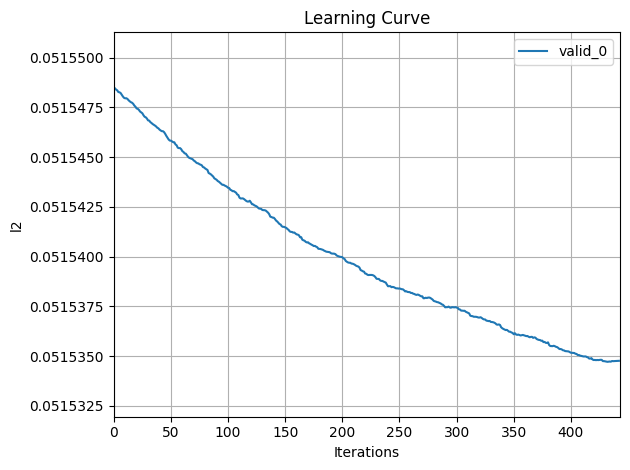

In [14]:
model.visualize_learning_curve()

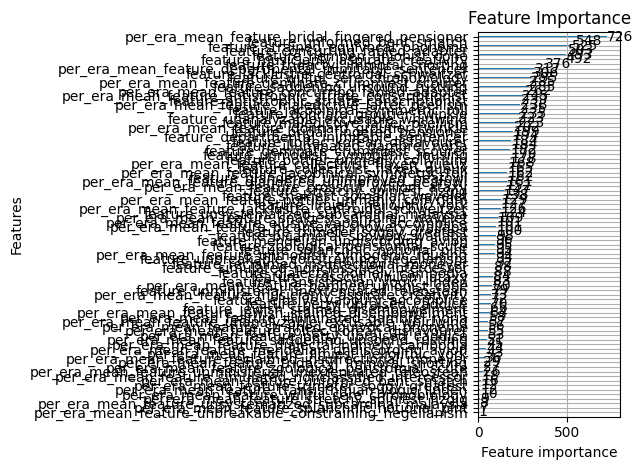

In [15]:
model.visualize_feature_importance()

# Validation

In [16]:
valid_pred = model.predict(valid[features])
valid["pred"] = valid_pred

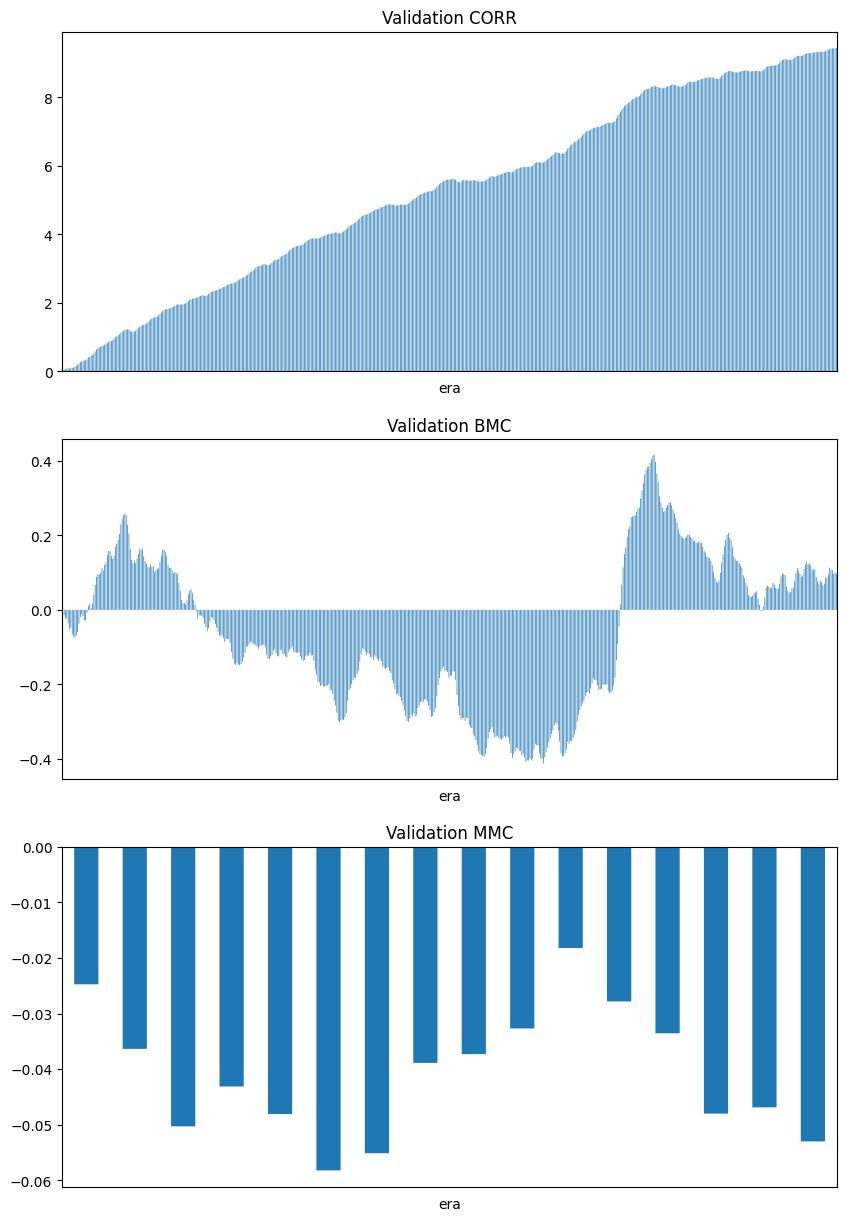

(   corr_mean  corr_std  corr_shape  corr_max_drawdown  mmc_mean  mmc_std  \
 0   0.016469  0.017351    0.949128           0.105748 -0.003313  0.01103   
 
    mmc_shape  mmc_max_drawdown  bmc_mean   bmc_std  bmc_shape  \
 0  -0.300305          0.034807  0.000169  0.013267   0.012703   
 
    bmc_max_drawdown  
 0          0.671019  ,
           pred
 era           
 0575  0.040615
 0576  0.006278
 0577  0.017126
 0578  0.021728
 0579 -0.000919
 ...        ...
 1144  0.014082
 1145  0.003165
 1146 -0.004140
 1147  0.013600
 1148  0.007522
 
 [574 rows x 1 columns],
           pred
 era           
 0575  0.005592
 0576 -0.020323
 0577 -0.007381
 0578 -0.002033
 0579 -0.012185
 ...        ...
 1144 -0.005690
 1145 -0.001507
 1146 -0.009375
 1147  0.004481
 1148 -0.004504
 
 [574 rows x 1 columns],
           pred
 era           
 1133 -0.024734
 1134 -0.011616
 1135 -0.013943
 1136  0.007174
 1137 -0.004955
 1138 -0.010149
 1139  0.003096
 1140  0.016254
 1141  0.001582
 1142  0.004618
 

In [17]:
caluculate_metrics(cfg.dataset_path, valid[["era", "pred", "target"]])